In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
from matplotlib import cm

from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination

directories = {
    'alexnet'   : '../AlexNet/evaluations/saves/2023-08-20-01-53-10/epoch_19_90.2_91.3.pth/',
    'mobilenet' : '../MobileNet/evaluations/saves/MobileNetV2WithExits/2023-08-20-05-20-25/epoch_19_89.7_90.9.pth',
}

'''
3 objetivos:
- Acurácia total do sistema
- Taxa de aceite
- Tempo médio de inferência

4 parâmetros -> 
Limiar de normal / ataque na primeira
Limiar de normal / ataque na segunda
'''

def get_objectives(df, normal_threshold_exit1, attack_threshold_exit1, normal_threshold_exit2, attack_threshold_exit2):
    f_n_exit1 = 'y_exit_1 == 0 and cnf_exit_1 >= @normal_threshold_exit1'
    f_a_exit1 = 'y_exit_1 == 1 and cnf_exit_1 >= @attack_threshold_exit1'

    f_n_exit2 = 'y_exit_2 == 0 and cnf_exit_2 >= @normal_threshold_exit2'
    f_a_exit2 = 'y_exit_2 == 1 and cnf_exit_2 >= @attack_threshold_exit2'

    exit1_normal = df.query(f_n_exit1)
    exit1_attack = df.query(f_a_exit1)

    exit2 = df.query(f'not ({f_n_exit1}) and not ({f_a_exit1})')

    exit2_normal = exit2.query(f_n_exit2)
    exit2_attack = exit2.query(f_a_exit2)

    not_accepted = exit2.query(f'not ({f_n_exit2}) and not ({f_a_exit2})')

    total = df['y'].count()

    exit1_normal_cnt = exit1_normal['y'].count()
    exit1_attack_cnt = exit1_attack['y'].count()
    exit2_normal_cnt = exit2_normal['y'].count()
    exit2_attack_cnt = exit2_attack['y'].count()

    accepted = exit1_normal_cnt + exit1_attack_cnt + exit2_normal_cnt + exit2_attack_cnt

    acceptance_rate = accepted / total

    correct = exit1_normal.query('y == y_exit_1')['y'].count() + \
              exit1_attack.query('y == y_exit_1')['y'].count() + \
              exit2_normal.query('y == y_exit_2')['y'].count() + \
              exit2_attack.query('y == y_exit_2')['y'].count()

    accuracy = correct / accepted

    exit1_total_time = exit1_normal['bb_time_exit_1'].sum() + exit1_normal['exit_time_exit_1'].sum() + \
                       exit1_attack['bb_time_exit_1'].sum() + exit1_attack['exit_time_exit_1'].sum()

    exit2_total_time = exit2_normal['bb_time_exit_1'].sum() + exit2_normal['bb_time_exit_2'].sum() + exit2_normal['exit_time_exit_2'].sum() + \
                       exit2_attack['bb_time_exit_1'].sum() + exit2_attack['bb_time_exit_2'].sum() + exit2_attack['exit_time_exit_2'].sum()

    not_accepted_total_time = not_accepted['bb_time_exit_1'].sum() + not_accepted['bb_time_exit_2'].sum() + not_accepted['exit_time_exit_2'].sum()

    total_time = exit1_total_time + exit2_total_time + not_accepted_total_time

    # print(f"Total: {total}")
    # print(f"exit1_normal_cnt: {exit1_normal_cnt}, exit1_attack_cnt: {exit1_attack_cnt}")
    # print(f"exit2_normal_cnt: {exit2_normal_cnt}, exit2_attack_cnt: {exit2_attack_cnt}")
    # print(f"Accepted: {accepted}, Accepted: {total - not_accepted['y'].count()}")
    # print(f"exit1_total_time: {exit1_total_time:.4f}, exit2_total_time: {exit2_total_time:.4f}, not_accepted_total_time: {not_accepted_total_time:.4f}")
    # print(f"exit1_rate: {100 * ( exit1_normal_cnt + exit1_attack_cnt ) / total:.2f}, exit2_rate: {100 * ( exit2_normal_cnt + exit2_attack_cnt ) / total:.2f}")
    # print(f"Accuracy: {100 * accuracy:.2f}, Acceptance: {100 * acceptance_rate:.2f}, Average Time: {1e6 * total_time / total:.2f}")

    return [ accuracy, acceptance_rate, 1e6 * total_time / total ]

def get_values(df, x1, x2, x3, x4):
    accuracy, acceptance, time = get_objectives(df, x1, x2, x3, x4)
    return [ 1 - accuracy, 1 - acceptance, (time - min_time) / (max_time - min_time) ]

def plot(network, *cnfs):
    directory = directories[network]

    datapoints = {
        'network' : network,
        'labels' : [],
        'accuracy_e1' : [],
        'accuracy_e2' : [],
        'accuracy_model' : [],
        'acceptance_e1' : [],
        'acceptance_e2' : [],
        'acceptance_model' : [],
        'time_e1' : [],
        'time_e2' : [],
        'time_model' : [],
    }

    for year in range(2016, 2020):
        year = f'{year:04d}'
        for month in range(1, 13):
            month = f'{month:02d}'
            glob = f'{year}_{month}'
            csv = os.path.join(directory, f'{glob}.csv')
            df = pd.read_csv(csv)
            
            accuracy_e1, acceptance_e1, time_e1 = get_objectives(df, 0, 0, 1, 1)
            accuracy_e2, acceptance_e2, time_e2 = get_objectives(df, 2, 2, 0, 0)
            accuracy, acceptance, time = get_objectives(df, *cnfs)

            datapoints['labels'].append(glob)
            datapoints['accuracy_e1'].append(accuracy_e1)
            datapoints['accuracy_e2'].append(accuracy_e2)
            datapoints['accuracy_model'].append(accuracy)
            datapoints['acceptance_e1'].append(acceptance_e1)
            datapoints['acceptance_e2'].append(acceptance_e2)
            datapoints['acceptance_model'].append(acceptance)
            datapoints['time_e1'].append(time_e1)
            datapoints['time_e2'].append(time_e2)
            datapoints['time_model'].append(time)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout='constrained')
    fig.autofmt_xdate(rotation=90)
    plt.title(f"Accuracy {datapoints['network']} - min cnf: {cnfs}")

    axs[0].plot(datapoints['labels'], datapoints['accuracy_e1'], label='accuracy_e1')
    axs[0].plot(datapoints['accuracy_e2'], label='accuracy_e2')
    axs[0].plot(datapoints['accuracy_model'], label='accuracy_model')
    axs[0].plot(datapoints['acceptance_model'], label='acceptance_model')            
    axs[0].legend()

    axs[1].plot(datapoints['labels'], datapoints['time_e1'], label='time_e1')
    axs[1].plot(datapoints['time_e2'], label='time_e2')
    axs[1].plot(datapoints['time_model'], label='time_model')
    axs[1].legend()
    
    plt.show

In [20]:
class MyProblem(ElementwiseProblem):
    def __init__(self, df):
        super().__init__(n_var=4,
                         n_obj=3,
                         n_ieq_constr=0,
                         xl=np.array([ 0.5, 0.5, 0.5, 0.5 ]),
                         xu=np.array([ 1, 1, 1, 1 ]))
            
        self.df = df
        self.accuracy_e1, self.acceptance_e1, self.min_time = get_objectives(self.df, 0, 0, 1, 1)
        self.accuracy_e2, self.acceptance_e2, self.max_time = get_objectives(self.df, 2, 2, 0, 0)      

    def _evaluate(self, x, out, *args, **kwargs):
        accuracy, acceptance, time = get_objectives(self.df, *x)
        out["F"] = [ 1 - accuracy, 1 - acceptance, (time - self.min_time) / (self.max_time - self.min_time) ]
        out["G"] = []

def process(directory='alexnet', glob='2016_01'):
    directory = directories[directory]
    files = Path(directory).glob(f'*{glob}*')
    dfs = []
    for file in sorted(files):
        dfs.append(pd.read_csv(file))

    df = pd.concat(dfs, ignore_index=True)

    problem = MyProblem(df)

    algorithm = NSGA2(
        pop_size=100, # 100
        n_offsprings=80, # 80
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20),
        eliminate_duplicates=True
    )

    termination = get_termination("n_gen", 10) # 1000

    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    X = res.X
    F = res.F

    print(f'{directory}')
    print(f'{glob}')

    print(f'Exit1: {problem.accuracy_e1*100:.2f}% - {problem.acceptance_e1*100:.2f}% - {problem.min_time:.2f}us')
    print(f'Exit2: {problem.accuracy_e2*100:.2f}% - {problem.acceptance_e2*100:.2f}% - {problem.max_time:.2f}us')
    print()

    for i in range(len(F)):
        f = F[i]
        x = X[i]
        print(f'{i:02d}: {100 * (1 - f[0]):.2f}% : {100 * (1 - f[1]):.2f}% : {problem.min_time + (f[2] * (problem.max_time - problem.min_time)):.2f}us', end='')
        print(f'\t{x[0]:.4f} : {x[1]:.4f} : {x[2]:.4f} : {x[3]:.4f}')

    x = 100 * ( 1 - F[:, 0])
    y = 100 * ( 1 - F[:, 1])
    z = problem.min_time + F[:, 2] * (problem.max_time - problem.min_time)
 
    # Creating figure
    fig = plt.figure(figsize = (15, 7))
    ax = plt.axes(projection ="3d")
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Acceptance')
    ax.set_zlabel('Time')

    # Creating plot
    ax.scatter3D(x, y, z, color = "green")
    plt.title("simple 3D scatter plot")

    ax.view_init(45, -45)
 
    # show plot
    plt.show()

    return X, F, problem.min_time, problem.max_time

In [ ]:
process('alexnet', '2016_01')

In [ ]:
plot('alexnet', 0.8453, 0.9688, 0.7744, 0.9284)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     49 |             - |             -
     2 |      180 |     72 |  0.1087076527 |         ideal
     3 |      260 |     92 |  0.5203813547 |         ideal
     4 |      340 |    100 |  0.0170701277 |         nadir
     5 |      420 |    100 |  0.0097148384 |             f
     6 |      500 |    100 |  0.0431599605 |         ideal
     7 |      580 |    100 |  0.0053876099 |         ideal
     8 |      660 |    100 |  0.0274905073 |         nadir
     9 |      740 |    100 |  0.2427208062 |         ideal
    10 |      820 |    100 |  0.0057067346 |             f
../AlexNet/evaluations/saves/2023-08-20-01-53-10/epoch_19_90.2_91.3.pth/
2016_0[23]
Exit1: 89.55% - 100.00% - 0.61us
Exit2: 90.26% - 100.00% - 1.54us

00: 89.55% : 100.00% : 0.61us	0.5023 : 0.5012 : 0.8348 : 0.7848
01: 92.60% : 75.84% : 1.47us	0.9850 : 0.9977 : 0.7728 : 0.9058
02: 98.11% : 19.34% : 1.44us	0.9370 : 0.9926 : 0.9843 : 0.9348
03: 89.56%

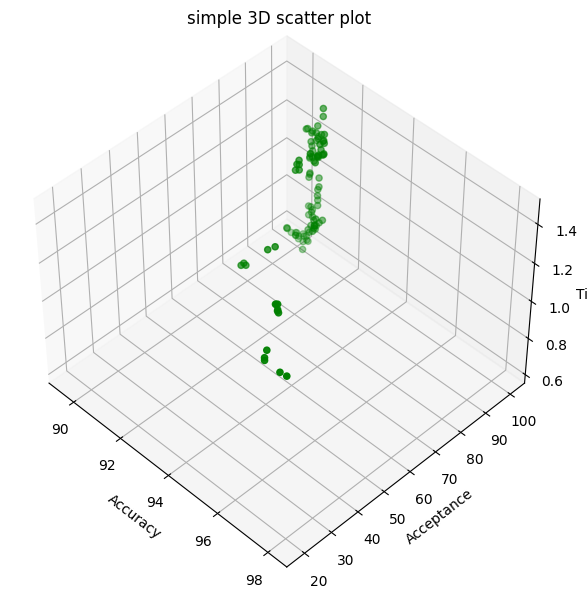

In [21]:
Xa, Fa, min_time, max_time = process('alexnet', '2016_0[23]')
with open('alexnet_x_f_2016_23.sav', 'wb') as f:
    pickle.dump([ Xa, Fa, min_time, max_time ], f)

In [31]:
with open('alexnet_x_f_2016_23.sav', 'rb') as f:
    Xa, Fa, min_time, max_time = pickle.load(f)

print([Xa, Fa, min_time, max_time])

[array([[0.50230382, 0.50116732, 0.83478748, 0.78481426],
       [0.98504962, 0.99767078, 0.77279848, 0.905838  ],
       [0.93699704, 0.99258148, 0.98431985, 0.93477436],
       [0.50140256, 0.50579311, 0.53295737, 0.53293693],
       [0.99009671, 0.95166932, 0.93591156, 0.87382639],
       [0.93481379, 0.96743023, 0.92621334, 0.91185276],
       [0.96557774, 0.79748977, 0.99683349, 0.91395082],
       [0.9753268 , 0.98260731, 0.79117623, 0.91358528],
       [0.93699704, 0.98959661, 0.98692901, 0.91416116],
       [0.94702852, 0.98468108, 0.98856873, 0.84722979],
       [0.93699704, 0.84733576, 0.98157229, 0.91416116],
       [0.93699704, 0.98125427, 0.98431985, 0.93477436],
       [0.98739928, 0.96508377, 0.93578933, 0.94059955],
       [0.94621634, 0.96493134, 0.92621334, 0.95438599],
       [0.75792716, 0.76223536, 0.64899287, 0.81078987],
       [0.83944229, 0.73815523, 0.74436714, 0.94582566],
       [0.97157502, 0.96508377, 0.97689552, 0.94059955],
       [0.86524971, 0.93768814

In [ ]:
plot('alexnet', 0.9825, 0.9993, 0.7071, 0.9111)

In [ ]:
process('mobilenet', '2016_01')

In [ ]:
plot('mobilenet', 0.9979, 0.9905, 0.9314, 0.9141)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |     17 |             - |             -
     2 |       40 |     20 |  0.0480953611 |         nadir
     3 |       60 |     20 |  0.0087767819 |         ideal
     4 |       80 |     20 |  0.1109414311 |         ideal
     5 |      100 |     20 |  0.3550078138 |         ideal
     6 |      120 |     20 |  0.0532108875 |         ideal
     7 |      140 |     20 |  0.0249937936 |         ideal
     8 |      160 |     20 |  0.0109258902 |         ideal
     9 |      180 |     20 |  0.0271247519 |         ideal
    10 |      200 |     20 |  0.0059810181 |         nadir
../MobileNet/evaluations/saves/MobileNetV2WithExits/2023-08-20-05-20-25/epoch_19_89.7_90.9.pth
2016_0[23]
Exit1: 89.60% - 100.00% - 2.27us
Exit2: 90.08% - 100.00% - 9.28us

00: 93.58% : 89.53% : 8.98us	0.9949 : 0.9930 : 0.8787 : 0.8662
01: 93.33% : 55.76% : 7.00us	0.9643 : 0.9400 : 0.8814 : 0.8549
02: 89.61% : 100.00% : 2.28us	0.5051 : 0.5218 : 0.89

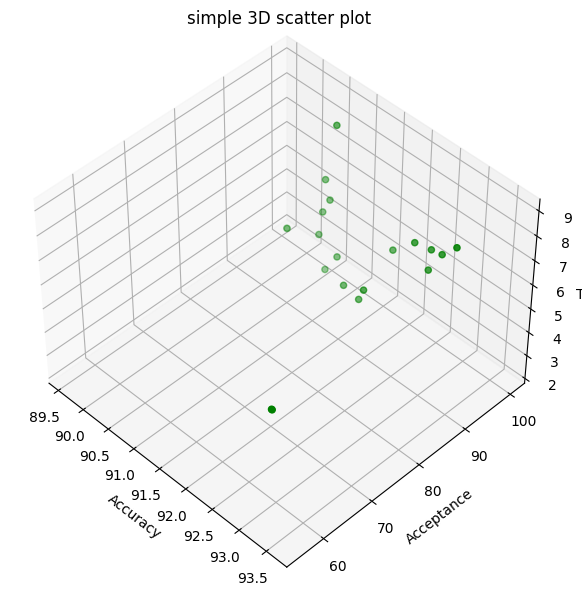

In [18]:
ls 

In [19]:
with open('mobilenet_x_f_2016_23.sav', 'rb') as f:
    Xm, Fm, min_time, max_time = pickle.load(f)

print([Xm, Fm, min_time, max_time])

[array([[0.99493577, 0.9929977 , 0.87874094, 0.86622242],
       [0.96427052, 0.94004565, 0.88137648, 0.85486845],
       [0.50510917, 0.52179711, 0.89334217, 0.50896104],
       [0.50005318, 0.53038104, 0.65461509, 0.52092305],
       [0.80378138, 0.99106729, 0.69883842, 0.88780504],
       [0.96427052, 0.93961861, 0.88137648, 0.85486845],
       [0.80933481, 0.9372635 , 0.69883842, 0.88780504],
       [0.82189989, 0.86806877, 0.65617235, 0.87706875],
       [0.57490179, 0.91018575, 0.84499719, 0.86622242],
       [0.96760734, 0.85793188, 0.70045006, 0.51510778],
       [0.98236489, 0.90097846, 0.87874027, 0.86932213],
       [0.98881549, 0.97579136, 0.69528749, 0.515673  ],
       [0.96339996, 0.90802418, 0.87732882, 0.87753965],
       [0.80927673, 0.94964594, 0.71053165, 0.88787725],
       [0.96375429, 0.67581202, 0.87874094, 0.86620843],
       [0.56526119, 0.90304205, 0.85589201, 0.83722903],
       [0.54599802, 0.96905091, 0.70842013, 0.65854433],
       [0.99493577, 0.91018575

In [ ]:
plot('mobilenet', 0.7949, 0.8820, 0.9273, 0.9338)

In [26]:
len(Fa)

100

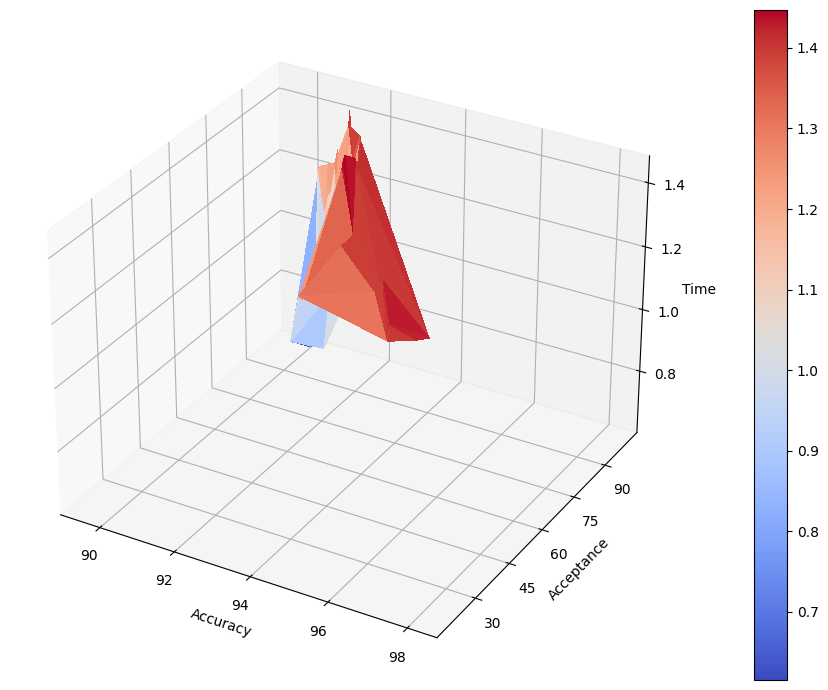

In [54]:
with open('alexnet_x_f_2016_23.sav', 'rb') as f:
    X, F, min_time, max_time = pickle.load(f)

x = 100 * ( 1 - F[:, 0])
y = 100 * ( 1 - F[:, 1])
z = min_time + F[:, 2] * (max_time - min_time)

# x = F[:, 0]
# y = F[:, 1]
# z = F[:, 2]

fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Accuracy')
ax.set_ylabel('Acceptance')
ax.set_zlabel('Time')

surf = ax.plot_trisurf(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.show()

In [55]:
import numpy as np
from mayavi import mlab

X = 100 * ( 1 - F[:, 0])
Y = 100 * ( 1 - F[:, 1])
Z = min_time + F[:, 2] * (max_time - min_time)

# Define the points in 3D space
# including color code based on Z coordinate.
pts = mlab.points3d(X, Y, Z, Z)

# Triangulate based on X, Y with Delaunay 2D algorithm.
# Save resulting triangulation.
mesh = mlab.pipeline.delaunay2d(pts)

# Remove the point representation from the plot
pts.remove()

# Draw a surface based on the triangulation
surf = mlab.pipeline.surface(mesh)

# Simple plot.
mlab.xlabel("x")
mlab.ylabel("y")
mlab.zlabel("z")
mlab.show()

ModuleNotFoundError: No module named 'mayavi'

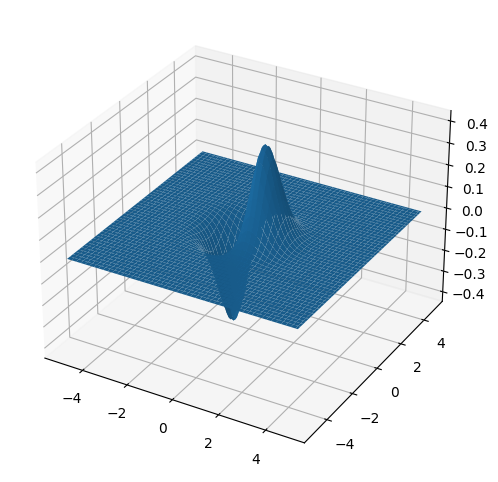

In [67]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
#if using a Jupyter notebook, include:
%matplotlib inline

x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X,Y = np.meshgrid(x,y)
Z = X*np.exp(-X ** 2 - Y ** 2)


fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')


# Plot a 3D surface
ax.plot_surface(X, Y, Z)


plt.show()

In [72]:
Z[1]

array([-2.59535904e-21, -6.84502532e-21, -1.76882906e-20, -4.47839341e-20,
       -1.11090286e-19, -2.69984446e-19, -6.42837193e-19, -1.49952246e-18,
       -3.42676340e-18, -7.67154974e-18, -1.68243297e-17, -3.61439012e-17,
       -7.60607787e-17, -1.56783284e-16, -3.16545034e-16, -6.25965115e-16,
       -1.21233933e-15, -2.29951645e-15, -4.27133833e-15, -7.76928785e-15,
       -1.38375884e-14, -2.41307541e-14, -4.11982513e-14, -6.88567437e-14,
       -1.12650245e-13, -1.80380251e-13, -2.82660105e-13, -4.33410588e-13,
       -6.50169927e-13, -9.54047766e-13, -1.36912014e-12, -1.92105594e-12,
       -2.63480133e-12, -3.53124100e-12, -4.62291170e-12, -5.90905680e-12,
       -7.37055753e-12, -8.96551347e-12, -1.06264128e-11, -1.22598696e-11,
       -1.37497565e-11, -1.49641988e-11, -1.57663444e-11, -1.60281439e-11,
       -1.56456902e-11, -1.45541174e-11, -1.27397928e-11, -1.02476490e-11,
       -7.18203812e-12, -3.70038187e-12, -6.63926039e-25,  3.70038187e-12,
        7.18203812e-12,  